In [26]:
import numpy as np
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/statsmodels/statsmodels/main/statsmodels/datasets/macrodata/macrodata.csv',index_col=0,parse_dates=True)
df.head()

,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
year,,,,,,,,,,,,,
1959-01-01,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-01-01,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-01-01,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-01-01,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


# 1. Hodrick-Prescott filter
    
The <a href='https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter'>Hodrick-Prescott filter</a> separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$

$y_t = \tau_t + c_t$

The components are determined by minimizing the following quadratic loss function, where $\lambda$ is a smoothing parameter:

$\min_{\\{ \tau_{t}\\} }\sum_{t=1}^{T}c_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$


The $\lambda$ value above handles variations in the growth rate of the trend component.<br>When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

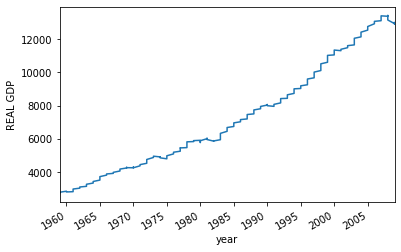

In [28]:
ax = df['realgdp'].plot()
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='REAL GDP');

In [29]:
gdp_cycle, gdp_trend = hpfilter(df['realgdp'], lamb=1600)
df['trend'] = gdp_trend

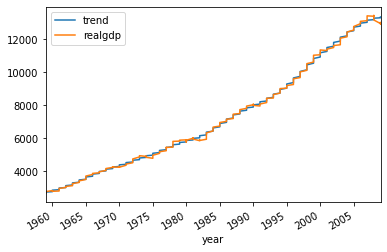

In [30]:
df[['trend','realgdp']].plot().autoscale(axis='x',tight=True);

# 2. ETS Decomposition

As we begin working with <em>endogenous</em> data ("endog" for short) and start to develop forecasting models, it helps to identify and isolate factors working within the system that influence behavior. Here the name "endogenous" considers internal factors, while "exogenous" would relate to external forces.

The <a href='https://en.wikipedia.org/wiki/Decomposition_of_time_series'>decomposition</a> of a time series attempts to isolate individual components such as <em>error</em>, <em>trend</em>, and <em>seasonality</em> (ETS). We've already seen a simplistic example of this in the <strong>Introduction to Statsmodels</strong> section with the Hodrick-Prescott filter. There we separated data into a trendline and a cyclical feature that mapped observed data back to the trend.

https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7

In [31]:
airline = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv',index_col='Month',parse_dates=True)
airline.dropna(inplace=True)
airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


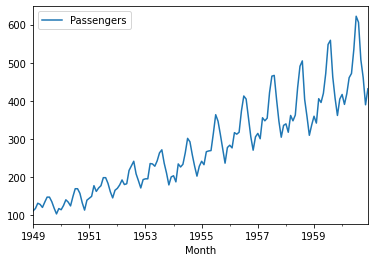

In [32]:
airline.plot();

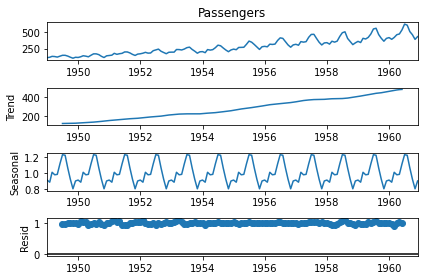

In [33]:
result = seasonal_decompose(airline['Passengers'], model='multiplicative')
result.plot();

#3. Moving Average

## 3.1 Simple Moving Average

In [34]:
airline = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv',index_col='Month',parse_dates=True)
airline.dropna(inplace=True)
airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


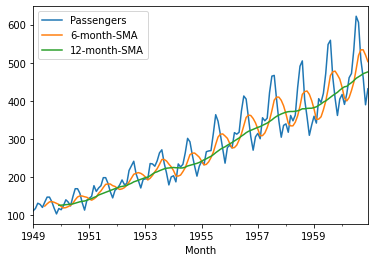

In [35]:
airline['6-month-SMA'] = airline['Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Passengers'].rolling(window=12).mean()
airline.plot()

##3.2 Exponentially Weighted Moving Average 

Basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
$y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

$y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

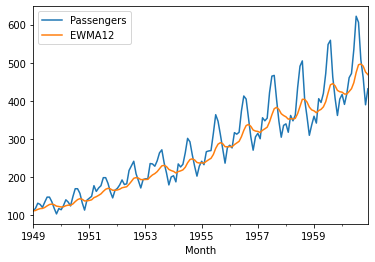

In [36]:
airline['EWMA12'] = airline['Passengers'].ewm(span=12,adjust=False).mean()
airline[['Passengers','EWMA12']].plot();

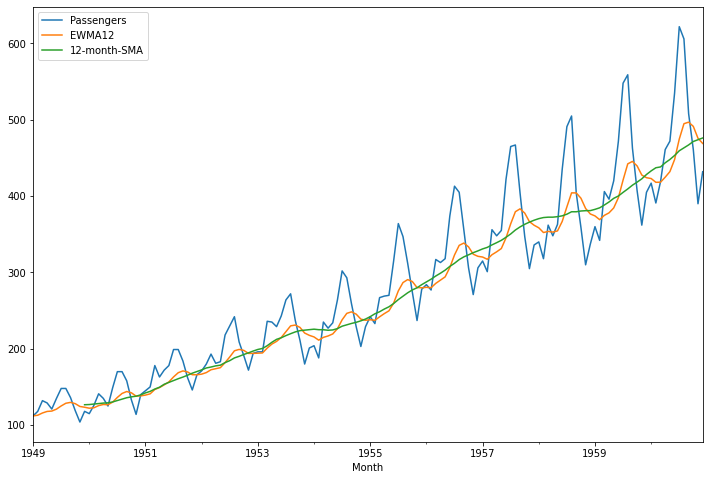

In [37]:
# Comparison
airline[['Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

# 4. Holt-Winters Methods
In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h6>Related Functions:</h6>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    
<h6>For Further Reading:</h6>
<tt>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm'>NIST/SEMATECH e-Handbook of Statistical Methods</a></strong>&nbsp;&nbsp;<font>What is Exponential Smoothing?</font></tt></div>

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-airline-passengers.csv',index_col='Month', parse_dates=True)
df.dropna(inplace=True)
df.index.freq = 'MS'
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 4.1 Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [39]:
span = 12
alpha = 2 / (span+1)

df['EWMA12'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

df['SES12'] = SimpleExpSmoothing(df['Passengers'])\
  .fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)
  
df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

## 4.2 Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [40]:
df['DESadd12'] = ExponentialSmoothing(df['Passengers'], trend='add')\
.fit().fittedvalues.shift(-1)
df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,113.474828
1949-02-01,118,112.923077,112.923077,119.464366
1949-03-01,132,115.857988,115.857988,133.477561
1949-04-01,129,117.879836,117.879836,130.543312
1949-05-01,121,118.359861,118.359861,122.528126


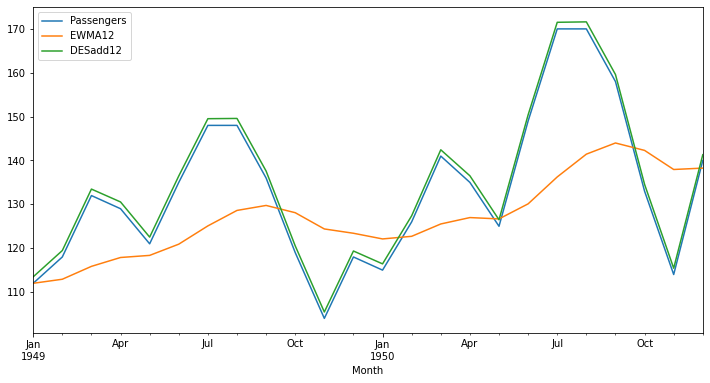

In [41]:
df[['Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [42]:
df['DESmul12'] = ExponentialSmoothing(df['Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,113.474828,114.978251
1949-02-01,118,112.923077,112.923077,119.464366,121.191659
1949-03-01,132,115.857988,115.857988,133.477561,135.802180
1949-04-01,129,117.879836,117.879836,130.543312,132.657709
1949-05-01,121,118.359861,118.359861,122.528126,124.213566


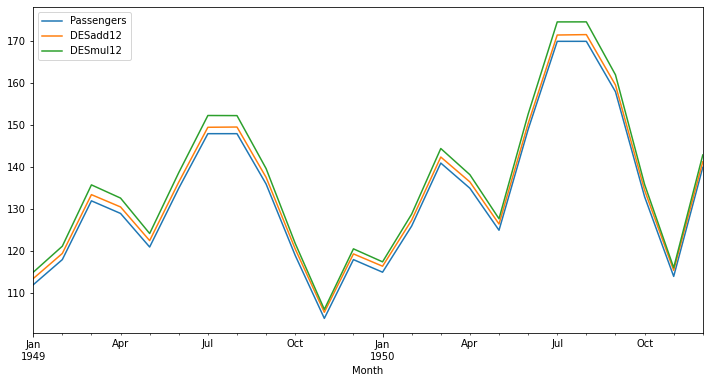

In [43]:
df[['Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

## 4.3 Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [44]:
df['TESadd12'] = ExponentialSmoothing(df['Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


,Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,113.474828,114.978251,112.001172
1949-02-01,118,112.923077,112.923077,119.464366,121.191659,120.168193
1949-03-01,132,115.857988,115.857988,133.477561,135.802180,134.698694
1949-04-01,129,117.879836,117.879836,130.543312,132.657709,131.376310
1949-05-01,121,118.359861,118.359861,122.528126,124.213566,124.628035


In [45]:
df['TESmul12'] = ExponentialSmoothing(df['Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,113.474828,114.978251,112.001172,111.597879
1949-02-01,118,112.923077,112.923077,119.464366,121.191659,120.168193,118.844235
1949-03-01,132,115.857988,115.857988,133.477561,135.802180,134.698694,133.334951
1949-04-01,129,117.879836,117.879836,130.543312,132.657709,131.376310,127.901291
1949-05-01,121,118.359861,118.359861,122.528126,124.213566,124.628035,120.978657


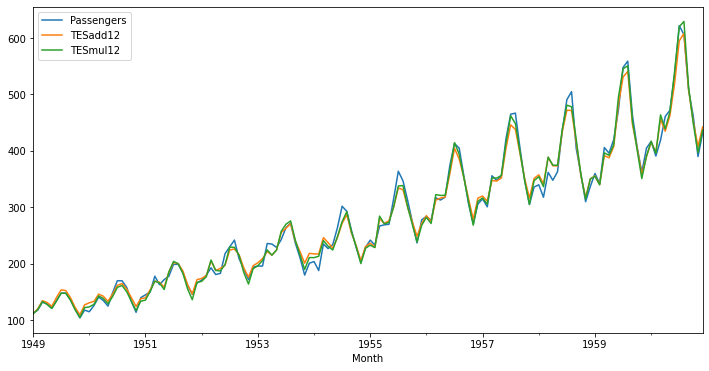

In [46]:
df[['Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

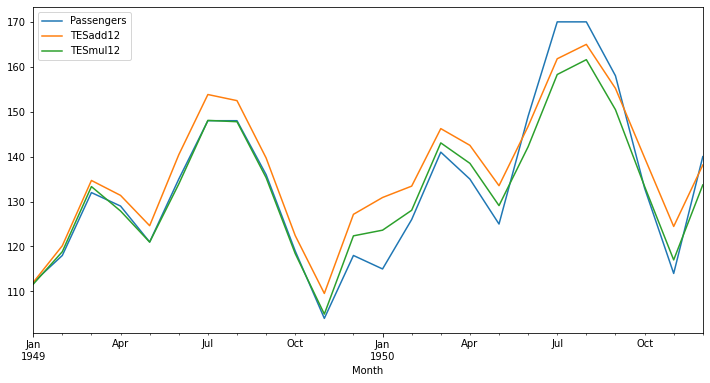

In [47]:
df[['Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - <em>forecasting</em>. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

# 5. Time Series Behaviours

## 5.1 Stationarity
Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>

<div class="alert alert-info">For Further Reading:
<strong>
<a href='https://otexts.com/fpp2/stationarity.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Stationarity and differencing</font></div>

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/ChanCheeKean/datasets/main/pandas/samples.csv',index_col=0,parse_dates=True)
df.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


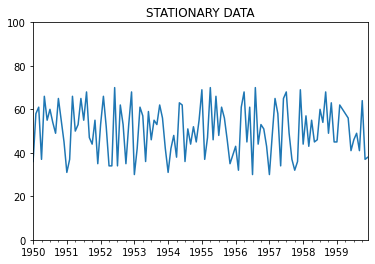

In [49]:
df['a'].plot(ylim=[0,100],title="STATIONARY DATA").autoscale(axis='x',tight=True);

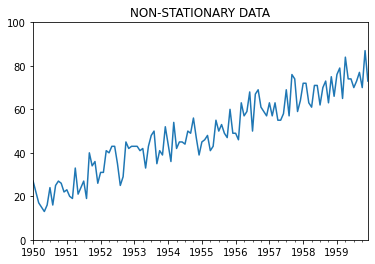

In [50]:
df['b'].plot(ylim=[0,100],title="NON-STATIONARY DATA").autoscale(axis='x',tight=True);

##  5.2 Differencing

### 5.2.1 First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

In [51]:
# Calculate the first difference of the non-stationary dataset "b"
df['d1b'] = df['b'] - df['b'].shift(1)
df[['b','d1b']].head()

,b,d1b
1950-01-01,27,NaN
1950-02-01,22,-5.0
1950-03-01,17,-5.0
1950-04-01,15,-2.0
1950-05-01,13,-2.0


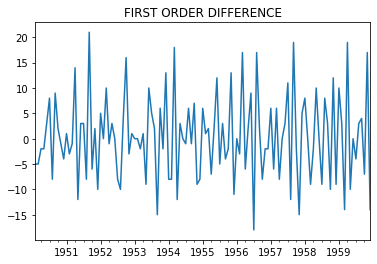

In [52]:
df['d1b'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

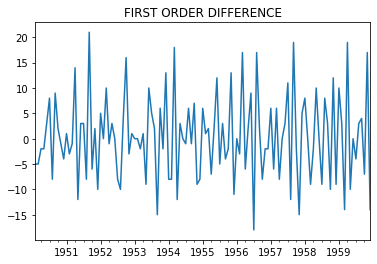

In [53]:
# easier way
df['d1b'] = df['b'].diff()
df['d1b'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

### 5.2.2 Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

In [54]:
# We can do this from the original time series in one step
df['d1c'] = df['c'].diff()
df['d2c'] = df['c'].diff().diff()
df[['c','d1c','d2c']].head()

,c,d1c,d2c
1950-01-01,0,NaN,NaN
1950-02-01,3,3.0,NaN
1950-03-01,5,2.0,-1.0
1950-04-01,8,3.0,1.0
1950-05-01,8,0.0,-3.0


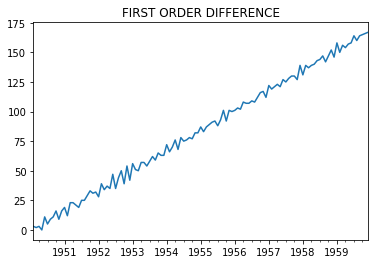

In [55]:
df['d1c'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

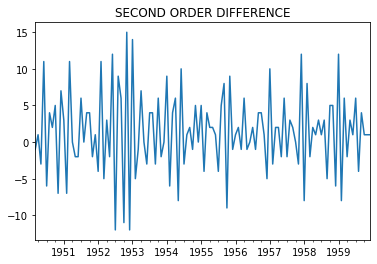

In [56]:
df['d2c'].plot(title="SECOND ORDER DIFFERENCE").autoscale(axis='x',tight=True);

<div class="alert alert-info"><strong>NOTE: </strong>This is different from <font color=black><tt>df2['c'].diff(2)</tt></font>, which would provide a first order difference spaced 2 lags apart.<br>
We'll use this technique later to address seasonality.</div>

### 5.2.3 Inverting Differenced data to original

In [57]:
# build a forecast series from scratch
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


In [58]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df['c'].iloc[-1] - df['c'].iloc[-2]) + z['Fcast'].cumsum()
# Now build the forecast values from the first difference set
z['forecast'] = df['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


# 6. Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>
